In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pathlib as Path

import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import pathlib as Path
import pandas as pd
from tqdm import tqdm
from torch.nn import BCEWithLogitsLoss
import datetime



from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#importing dataset labels encoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

In [3]:
class CustomBERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CustomBERTClassifier, self).__init__()
        # Loading pre-implemented BERT model
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        # Custom additional layers
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        # BERT model
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Extracting CLS token representation
        cls_output = bert_outputs["last_hidden_state"][:, 0, :]
        # Custom layers
        x = self.fc1(cls_output)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

model = CustomBERTClassifier(num_classes=3)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
# DATA READING
train_data = pd.read_csv('train.csv', encoding='ISO-8859-1')
test_data = pd.read_csv('test.csv', encoding='ISO-8859-1')

# Dropping null values
if (train_data['sentiment'].isnull().sum() > 0) or (test_data['sentiment'].isnull().sum() > 0):
    train_data['sentiment'].fillna(" ", inplace=True)
    test_data = test_data.dropna(subset=['sentiment'])
train_data['text'].fillna(" ", inplace=True)
test_data['text'].fillna(" ", inplace=True)

# Encoding labels
le = LabelEncoder()
train_data['labels'] = le.fit_transform(train_data['sentiment'])
test_data['labels'] = le.fit_transform(test_data['sentiment'])


# Dropping unnecessary columns
train_data = train_data[['text', 'labels']]
test_data = test_data[['text', 'labels']]

# One hot encoding
one_hot = OneHotEncoder()
train_data['labels'] = one_hot.fit_transform(train_data[['labels']]).toarray().tolist()
test_data['labels'] = one_hot.fit_transform(test_data[['labels']]).toarray().tolist()

# Dataset creation and DataLoader
triain_texts = train_data['text'].tolist()
test_texts = test_data['text'].tolist()

max_length = 256
train_dataset = TextDataset(triain_texts, train_data['labels'], tokenizer, max_length)
test_dataset = TextDataset(test_texts, test_data['labels'], tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [6]:
def train_model(model, epoch, num_epochs, train_dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    # Initialize tqdm to show progress bar
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=True)

    for batch_idx, batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Update progress bar
        loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss

In [7]:
def test(model, test_dataloader, criterion, device):
    model.eval()
    total_loss = 0

    # Initialize tqdm to show progress bar
    loop = tqdm(enumerate(test_dataloader), total=len(test_dataloader), leave=True)

    for batch_idx, batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            # Update progress bar
            loop.set_description(f"Test")
            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(test_dataloader)
    return avg_loss

In [9]:
# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type != "cuda":
    raise Exception("=== GPU not found ===")

# Model, optimizer, criterion initialization
optimizer = Adam(model.parameters(), lr=1e-5)
criterion = BCEWithLogitsLoss()
num_epochs = 10

model.to(device)
# Training loop
for epoch in range(num_epochs):
    loss = train_model(model, epoch, num_epochs, train_loader, optimizer, criterion, device)
    print(f"Epoch: {epoch+1}, Loss: {loss:.4f}")

Epoch 1/10: 100%|██████████| 859/859 [19:15<00:00,  1.35s/it, loss=0.647]


Epoch: 1, Loss: 0.6585


Epoch 2/10: 100%|██████████| 859/859 [19:18<00:00,  1.35s/it, loss=0.657]


Epoch: 2, Loss: 0.6335


Epoch 3/10: 100%|██████████| 859/859 [19:19<00:00,  1.35s/it, loss=0.628]


Epoch: 3, Loss: 0.6267


Epoch 4/10: 100%|██████████| 859/859 [19:16<00:00,  1.35s/it, loss=0.594]


Epoch: 4, Loss: 0.6225


Epoch 5/10: 100%|██████████| 859/859 [19:17<00:00,  1.35s/it, loss=0.645]


Epoch: 5, Loss: 0.6195


Epoch 6/10: 100%|██████████| 859/859 [19:15<00:00,  1.35s/it, loss=0.604]


Epoch: 6, Loss: 0.6167


Epoch 7/10: 100%|██████████| 859/859 [19:16<00:00,  1.35s/it, loss=0.644]


Epoch: 7, Loss: 0.6151


Epoch 8/10: 100%|██████████| 859/859 [19:17<00:00,  1.35s/it, loss=0.621]


Epoch: 8, Loss: 0.6128


Epoch 9/10: 100%|██████████| 859/859 [19:17<00:00,  1.35s/it, loss=0.597]


Epoch: 9, Loss: 0.6116


Epoch 10/10: 100%|██████████| 859/859 [19:17<00:00,  1.35s/it, loss=0.653]

Epoch: 10, Loss: 0.6110


In [10]:
# EVALUATION
test_loss = test(model, test_loader, criterion, device)

if test_loss < 1.0:
    date_time = datetime.datetime.now().strftime("%Y-%m-%d_%H%M")
    file_name = f"model_checkpoint_{date_time}_loss{test_loss:.3f}.pth"
    torch.save({
        'epoch' : num_epochs,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'loss' : test_loss,
        }, file_name)
    print('Model saved')

Test: 100%|██████████| 111/111 [00:50<00:00,  2.19it/s, loss=0.614]


Model saved


In [11]:
# Finding Accuracy
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            outputs = torch.sigmoid(outputs)
            predictions.append(outputs)
            real_values.append(labels)
    predictions = torch.cat(predictions).cpu()
    real_values = torch.cat(real_values).cpu()
    return predictions, real_values

y_pred, y_test = get_predictions(model, test_loader)

# Converting y_pred to one hot encoded data
y_pred = torch.argmax(y_pred, dim=1)

# Converting y_test to one hot encoded data tensor
y_pred = torch.tensor(one_hot.fit_transform(y_pred.reshape(-1, 1)).toarray().tolist())

3534


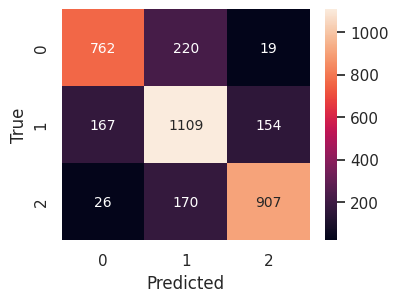

In [12]:
y_pred = torch.argmax(y_pred, axis=1).numpy()
y_test = torch.argmax(y_test, axis=1).numpy()

# Generate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
print(len(test_data))
# Plotting the confusion matrix using seaborn
plt.figure(figsize=(4,3))
sns.set(font_scale=1) # for label size
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 10}, fmt='g') # fmt='g' to display numbers as integers
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.7861
Precision: 0.7875
Recall: 0.7861
F1 Score: 0.7865
